### Notebook to compute stats values for tfrecord Aqua
Band 4, 7, 20, 28, 29, 31

In [2]:
%matplotlib inline
import os
import re
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.data import parallel_interleave
from netCDF4 import Dataset
from pyhdf.SD import SD, SDC

In [3]:
def data_extractor_resize_fn(filelist,prefetch=1,height=32,width=32,channel=6,read_threads=4, distribute=(1, 0)):
    def parser(ser):
        """
        Decode & Pass datast in tf.record
        *Cuation*
        floating point: tfrecord data ==> tf.float64
        """
        features = {
            "shape": tf.FixedLenFeature([3], tf.int64),
            "patch": tf.FixedLenFeature([], tf.string),
            "filename": tf.FixedLenFeature([], tf.string),
            "coordinate": tf.FixedLenFeature([2], tf.int64),
        }
        decoded = tf.parse_single_example(ser, features)
        patch = tf.reshape(
            tf.decode_raw(decoded["patch"], tf.float64), decoded["shape"]
        )
        # conversion of tensor
        patch = tf.cast(patch, tf.float64)
        patch = tf.image.resize_images(patch, (height, width))
        ## debug
        patch = tf.expand_dims(patch, axis=0)
        patch = tf.nn.avg_pool(patch, ksize=[1,1,1,1],
                               strides=[1,1,1,1], padding='SAME',)

        return patch
    
    dataset = (
        tf.data.Dataset.list_files(filelist, shuffle=True)
            .shard(*distribute)
            .apply(
            parallel_interleave(
                lambda f: tf.data.TFRecordDataset(f).map(parser),
                cycle_length=read_threads,
                sloppy=True,
            )
        )
    )
    iterator = dataset.make_one_shot_iterator()

    next_element = iterator.get_next()
    patches_list = []
    with tf.Session() as sess:
        try:
            while True:
                patch = sess.run(next_element)
                patches_list.append(patch)
        except tf.errors.OutOfRangeError:
            print("OutOfRage --> finish process")
            pass
    return patches_list

### Load data

In [4]:
tf_datadir  = '/home/tkurihana/Research/data/tfrecords/clouds_MYD_laads_rawdecoded_20160101'

In [ ]:
height = width = 128
## load 
filelist = glob.glob(os.path.join(tf_datadir, '*.tfrecord'))

patches_list = []
for ifile in filelist:
    patches_list.extend(data_extractor_resize_fn([ifile],height=height,width=width,channel=6 ))
print("NORMAL END")


In [ ]:
len(patches_list), len(patches_list[0]), type(patches_list[0])

In [26]:
## get patch
channel = 6
patches = np.concatenate(
    [np.expand_dims(i, axis=0).reshape(1,height,width, channel) for i in patches_list],
    axis=0)
print(patches.shape)

(11901, 128, 128, 6)


In [27]:
del patches_list

In [28]:
import gc
gc.collect()

6276

##### Compute stats data

In [29]:
means = np.mean(patches, axis=(0,1,2) )

In [32]:
means

array([44.285553  ,  0.969749  ,  0.09079821,  0.42408854,  1.376691  ,
        1.376691  ], dtype=float32)

In [33]:
stdvs = np.std(patches, axis=(0,1,2) )

In [34]:
stdvs

array([106.959015  ,   2.3649344 ,   0.21597032,   1.1793927 ,
         2.4062886 ,   2.4300978 ], dtype=float32)

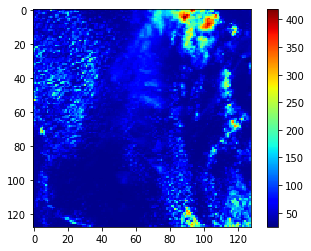

In [35]:
plt.figure()
plt.imshow(patches[0,:,:,0], cmap='jet')
plt.colorbar()

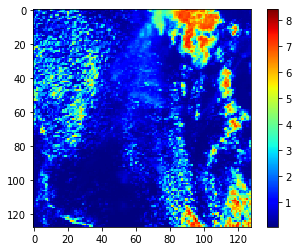

In [36]:
plt.figure()
plt.imshow(patches[0,:,:,1], cmap='jet')
plt.colorbar()

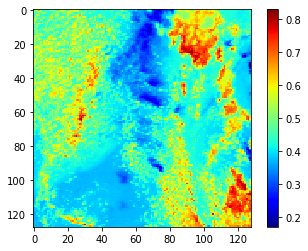

In [37]:
plt.figure()
plt.imshow(patches[0,:,:,2], cmap='jet')
plt.colorbar()

-------------------
#### Stats data in trained data 

In [38]:
stats_datadir = "/home/tkurihana/Research/data/tfrecords/clouds_laads_rawdecoded_2000_2018/global_mean_std"

In [41]:
npylist = glob.glob( os.path.join(stats_datadir, '*npy'))

In [42]:
data = []
for i in npylist:
    print(os.path.basename(i))
    data.append(np.load(i))

m2_02_band28_29_31_gstdv.npy
m2_02_band28_29_31_gmean.npy


In [43]:
data

[array([8.0684453 , 2.05904969, 0.14334577, 0.43814473, 1.05146903,
        1.09095932]),
 array([9.07279952, 2.22821143, 0.18822402, 1.90219873, 3.6511504 ,
        4.55727332])]

In [45]:
new_means_list = [ means[0].astype(np.float64) ] + [ i for i in data[1][1:]]
new_means_list

[44.285552978515625,
 2.228211426699908,
 0.18822402104913974,
 1.9021987280922097,
 3.651150400999267,
 4.557273324128586]

In [46]:
new_stdvs_list = [ stdvs[0].astype(np.float64) ] + [ i for i in data[0][1:]]
new_stdvs_list

[106.95901489257812,
 2.0590496947898864,
 0.14334576964701273,
 0.43814473040474095,
 1.0514690255864652,
 1.0909593198867436]

#### Save stast data in raw directory

In [47]:
save_stastdir = os.path.join(tf_datadir, 'global_mean_std')

In [52]:
save_stastdir

'/home/tkurihana/Research/data/tfrecords/clouds_MYD_laads_rawdecoded_20160101/global_mean_std'

In [49]:
os.makedirs(save_stastdir)

In [50]:
np.save(os.path.join(save_stastdir, "m2_02_band28_29_31_gmean.npy"), np.asarray(new_means_list))

In [51]:
np.save(os.path.join(save_stastdir, "m2_02_band28_29_31_gstdv.npy"), np.asarray(new_stdvs_list))

---------------------------------
## Compare NC and HDF dataset 

In [6]:
basedir = "/home/tkurihana/Research"
ncdata = os.path.join(basedir, "data3/201601/A2016.001.0000.nc")
hdfdata = os.path.join(basedir, "data/MYD02/20160101/MYD021KM.A2016001.0000.061.2018055020522.hdf")

##### Decode hdfdata

In [7]:
def read_hdf(hdf_file, varname='varname', sdsmax=32767):
    hdf = SD(hdf_file, SDC.READ)
    sds_array = hdf.select(varname)
    array = sds_array.get().astype(np.float64)
    err_idx = np.where( (array > sdsmax)
         & (array < sds_array.attributes()['_FillValue']) )
    array[err_idx] = np.nan
    
    # radiacne offset
    offset = sds_array.attributes()['radiance_offsets']
    offset_array = np.zeros(array.shape) # new matrix
    offset_ones  = np.ones(array.shape)  # 1 Matrix
    for iband in range(len(offset)):
        offset_array[iband, :,:] = array[iband, :,:] - offset[iband]*offset_ones[iband,:,:]
 
    # radiance scale
    scales = sds_array.attributes()['radiance_scales']
    scales_array = np.zeros(array.shape) # new matrix
    for iband in range(len(scales)):
        scales_array[iband, :,:] = scales[iband]*offset_array[iband,:,:]
    return scales_array

In [8]:
hdf_array = read_hdf(hdfdata, varname='EV_1KM_Emissive')
hdf_array.shape

(16, 2030, 1354)

##### Decode NC data

In [9]:
def importNetcdf(path=None, var_name=None):
    nc_fid=Dataset(path, 'r')
    field = nc_fid.variables[var_name][:]
    return field

In [10]:
nc_array = importNetcdf(ncdata, var_name='ev_1km_emissive_20')
nc_array.shape

(1, 1354, 2030)

- before scaling for hdf data

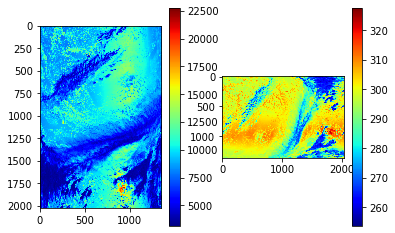

In [62]:
plt.figure(figsize=(6,4))
names = ['hdf band 20', 'nc band 20' ]
for idx, data in enumerate([hdf_array[0], nc_array[0]]):
    ax = plt.subplot(1,2,idx+1)
    plt.imshow(data, cmap='jet')
    plt.colorbar()
plt.show()

- afte scaling for HDF

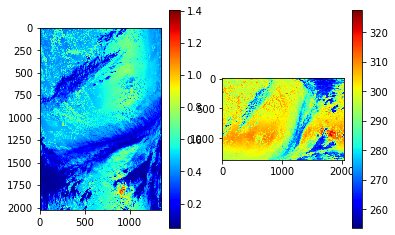

In [73]:
plt.figure(figsize=(6,4))
names = ['hdf band 20', 'nc band 20' ]
for idx, data in enumerate([hdf_array[0], nc_array[0]]):
    ax = plt.subplot(1,2,idx+1)
    plt.imshow(data, cmap='jet')
    plt.colorbar()
plt.show()

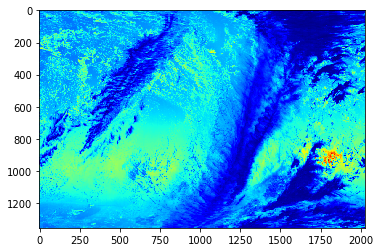

In [75]:
plt.imshow(hdf_array[0].T, cmap='jet')

After transpose Netcdf data

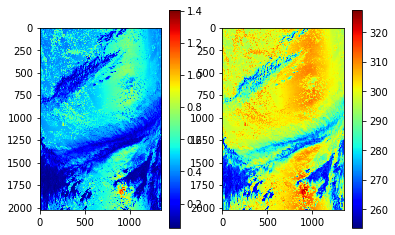

In [11]:
plt.figure(figsize=(6,4))
names = ['hdf band 20', 'nc band 20' ]
for idx, data in enumerate([hdf_array[0], nc_array[0].T]):
    ax = plt.subplot(1,2,idx+1)
    plt.imshow(data, cmap='jet')
    plt.colorbar()
plt.show()

#### MEMO: Do transport HDF array then corresponding to NC array

In [77]:
res = hdf_array[0].T - nc_array[0]

(array([   2030.,   15036.,  414976., 1034605.,  568068.,  222387.,
         172751.,  153737.,  148779.,   16251.]),
 array([-326.09591699, -318.85646173, -311.61700648, -304.37755122,
        -297.13809597, -289.89864071, -282.65918546, -275.4197302 ,
        -268.18027495, -260.94081969, -253.70136444]),
 <a list of 10 Patch objects>)

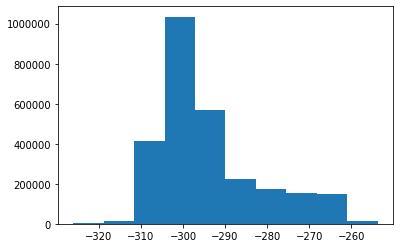

In [78]:
plt.hist(res.ravel())